In [1]:
# Increase width of the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data')
print(os.getcwd())
import numpy as np
import pandas as pd
pd.set_option('mode.use_inf_as_na', True)

# Plotting (x,y) with MatPlotLib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
plt.style.use("seaborn-poster") # notebook, paper, poster
# Plotting Tick Marks # https://matplotlib.org/stable/api/ticker_api.html
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator

# Plotting (x(t),y(t))
import datetime
from datetime import timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
years  =  mdates.YearLocator()
months =  mdates.MonthLocator()
days   =  mdates.DayLocator()
year_name = DateFormatter("%Y")
month_name = DateFormatter("%b")
day_name = DateFormatter('%d')

# Prohibit Warnings ()
import warnings 
warnings.filterwarnings('ignore')

# Importing necessary libraries for the models
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data


### Discharge Data (AGRO @ 1999 - 2022)

In [2]:
# Name File
AGRO4_Q = 'Arctic_GRO4_Discharge.txt'
# Import File (.txt)
dfq = pd.read_csv(AGRO4_Q, delim_whitespace=True, parse_dates=[0], index_col=[0], na_values = {'NA','A','', 'P'})
# Remove excess spaces from Column Text
dfq.columns = dfq.columns.str.strip()
# Yenisey River 
dfq= dfq.drop(columns={'Yukon','Yukon_flag','Mackenzie','Mackenzie_flag','Ob', 'Ob_flag', 'Lena', 'Lena_flag', 'Kolyma','Kolyma_flag','Yenisey_flag'})
# Rename Discharge Column
dfq = dfq.rename(columns={"Yenisey":"yq_m3/s"})

# Remove Partial Data
dfq = dfq.truncate(after='2021-12-31') 

# Perform interpolation
dfq = dfq.interpolate(method='piecewise_polynomial', order=6)

# Set Range for Modeling 
x_range = np.arange(5600, 169000, 1)

# Preview
dfq.head(3)

,yq_m3/s
Date,
1999-01-01,9700.0
1999-01-02,9750.0
1999-01-03,9800.0


In [3]:
nan_count = dfq.isna().sum()
print(nan_count)

yq_m3/s    0
dtype: int64


### Chemical Data (AGRO @ 2003 - 2022)

In [4]:
###############################################################################################
# Import ARCTICGRO4
AGRO4 = 'Arctic_GRO4_Chem.txt'
df4 = pd.read_csv(AGRO4, delim_whitespace=True, parse_dates=[1], na_values = {'NA','BD','','bdl'})
df4.columns = df4.columns.str.strip()
# Remove Apostraphe from Ob
df4['River'] = df4['River'].astype(str).str.replace("[']", "", regex=True)
df4.index = df4['River']
df4 = df4.rename(columns={"Temp":"T"})
###############################################################################################
# Reformat Dates
df4['year'] = pd.DatetimeIndex(df4['Date']).year
df4['month'] = pd.DatetimeIndex(df4['Date']).month
df4['day'] = pd.DatetimeIndex(df4['Date']).day
df4['month_day'] = df4['Date'].dt.strftime('%m-%d')
df4['month_day'] = pd.to_datetime(df4['month_day'],format='%m-%d',errors='coerce')
df4['month_'] = df4['Date'].dt.strftime('%m')
df4['month_'] = pd.to_datetime(df4['month_'],format='%m',errors='coerce')
df4 = df4.sort_values(by = ['month_','year'])
###############################################################################################
# Isolate Yenisey River Data
dfy = df4[df4.index == 'Yenisey']
# Change Index
dfy.index = dfy['Date']
# Sort Values
dfy = dfy.sort_values(by = ['year', 'month', 'day']) 

# Drop Date Columns
dfy = dfy.drop(columns='Date')

# Preview
dfy.head(3)

,River,T,pH,Cond,Alk,a254,a375,a412,a420,a440,...,TSS_2,POC_2,POC-13C_2,PON_2,PON-15N_2,year,month,day,month_day,month_
Date,,,,,,,,,,,,,,,,,,,,,
2003-07-25,Yenisey,16.7,8.0,NaN,58.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2003,7,25,1900-07-25,1900-07-01
2004-03-19,Yenisey,-0.1,7.3,NaN,67.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2004,3,19,1900-03-19,1900-03-01
2004-06-14,Yenisey,3.8,7.5,NaN,19.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2004,6,14,1900-06-14,1900-06-01


###### Folder for Images

In [5]:
# Folder for Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\AGRO_Yenisei_Predicted_Images')

### Merge Biogeochemical Parameters with Discharge Data

In [6]:
# Merge Biogeochemical Parameters with Discharge Data
dfy = pd.merge(dfq, dfy, left_index=True, right_index=True)
dfy.head(3)

,yq_m3/s,River,T,pH,Cond,Alk,a254,a375,a412,a420,...,TSS_2,POC_2,POC-13C_2,PON_2,PON-15N_2,year,month,day,month_day,month_
Date,,,,,,,,,,,,,,,,,,,,,
2003-07-25,17900.0,Yenisey,16.7,8.0,NaN,58.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2003,7,25,1900-07-25,1900-07-01
2004-03-19,7350.0,Yenisey,-0.1,7.3,NaN,67.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2004,3,19,1900-03-19,1900-03-01
2004-06-14,98200.0,Yenisey,3.8,7.5,NaN,19.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2004,6,14,1900-06-14,1900-06-01


In [7]:
nan_count = dfy.isna().sum()
list(nan_count)

[0,
 0,
 6,
 59,
 63,
 4,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 1,
 56,
 54,
 68,
 0,
 1,
 0,
 13,
 18,
 22,
 32,
 32,
 31,
 32,
 34,
 37,
 9,
 9,
 43,
 43,
 35,
 37,
 59,
 54,
 88,
 2,
 7,
 6,
 22,
 22,
 7,
 7,
 65,
 65,
 67,
 67,
 67,
 67,
 71,
 72,
 73,
 73,
 73,
 73,
 0,
 0,
 0,
 0,
 0]

### R2 Comparisons

# Regression Models

<br>

##### Natural Log Function
> a*np.log(x) + b 
- does not end at an asymptotic minimum, it keeps descending to negative values. 

<br>

##### Four-Parameter Logistic (4PL) Function
-   The 4PL function is often used in bioassays and dose-response curves due to its ability to handle both lower and upper asymptotes.
- seems like the best option. 

> D + (A - D) / (1 + (x / C)**B)
- A is the minimum asymptote.
- D is the maximum asymptote.
- B is the slope at the inflection point.
- C is the x-value of the inflection point.

In [8]:
Name = ['DOC', 'Alk', 'Ca', 'SO4', 'F']
R2_log = [0.79, 0.75, 0.79, 0.76, 0.55]
R2_4pl = [0.80, 0.76, 0.81, 0.79, 0.64]

feck = pd.DataFrame()
feck['Name'] = Name
feck['R2_log'] = R2_log
feck['R2_4pl'] = R2_4pl

# Monte Carlo Simulations

- Monte Carlo simulations are a powerful tool for understanding the uncertainty and variability inherent in models and processes. 

- They are widely used across various disciplines, especially when dealing with complex systems or when there's uncertainty in the input parameters.

- The inclusion of uncertainty bounds from Monte Carlo simulations can provide additional depth and robustness to your results, offering readers a clear view of the potential range of outcomes.

# 4PL

In [9]:
# Define the Four-Parameter Logistic (4PL) function for curve fitting
def four_parameter_logistic(x, A, B, C, D):
    return D + (A - D) / (1 + (x / C)**B)

<br><br><br>

# Alk

<br><br><br>

Fitted 4PL Model Coefficients:
A = 18.2
B = -1.9
C = 24383.0
D = 76.6
4PL Model Equation: y = 76.6 + (18.2 - 76.6) / (1 + (x / 24383.0)**-1.9)


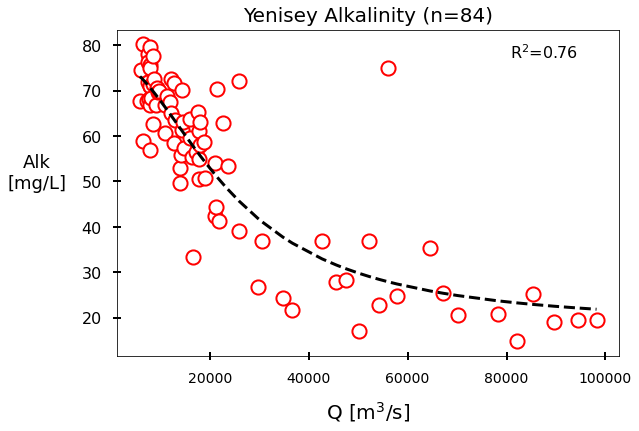

In [10]:
df_dfy = pd.DataFrame()
df_dfy['Alk'] = dfy['Alk']
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['Alk'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['Alk'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['Alk'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Print out the coefficients
print("Fitted 4PL Model Coefficients:")
print(f"A = {A_4PL:.1f}")
print(f"B = {B_4PL:.1f}")
print(f"C = {C_4PL:.1f}")
print(f"D = {D_4PL:.1f}")

# Format and print the resultant equation with one decimal place
equation = f"4PL Model Equation: y = {D_4PL:.1f} + ({A_4PL:.1f} - {D_4PL:.1f}) / (1 + (x / {C_4PL:.1f})**{B_4PL:.1f})"
print(equation)


# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['Alk'].mean())**2) / np.sum((df_dfy['Alk'] - df_dfy['Alk'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['Alk'], c='white', edgecolor='red', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisey Alkalinity (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('Alk\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.85, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_Alk_1.png', dpi = 500, bbox_inches='tight')

In [11]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

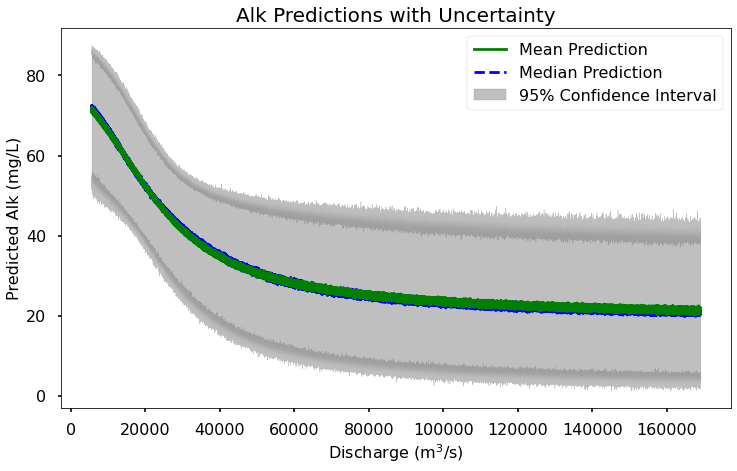

In [12]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='green', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('Alk Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted Alk (mg/L)', fontsize=16)
ax.legend(loc='upper right')

fig.savefig('AGRO_Yenisei_Predicted_Alk_2.png', dpi = 500, bbox_inches='tight')

In [13]:
# Create a new dataframe with Discharge and Mean Prediction
df_mean_predictions = pd.DataFrame({
    'Discharge': x_range,
    'Alk_Mean_Prediction': mean_predictions
})

df_mean_predictions.head(5)

,Discharge,Alk_Mean_Prediction
0,5600,71.175463
1,5601,71.472616
2,5602,71.469283
3,5603,70.814878
4,5604,71.032631


<br><br><br>

# DOC

<br><br><br>

Fitted 4PL Model Coefficients:
A = 1.6
B = 1.3
C = 29638.6
D = 13.8
4PL Model Equation: y = 13.8 + (1.6 - 13.8) / (1 + (x / 29638.6)**1.3)


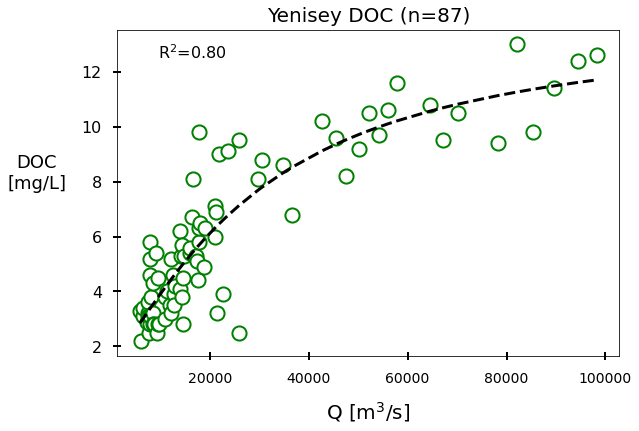

In [14]:
df_dfy = pd.DataFrame()
df_dfy['DOC'] = dfy['DOC']
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['DOC'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['DOC'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['DOC'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Print out the coefficients
print("Fitted 4PL Model Coefficients:")
print(f"A = {A_4PL:.1f}")
print(f"B = {B_4PL:.1f}")
print(f"C = {C_4PL:.1f}")
print(f"D = {D_4PL:.1f}")

# Format and print the resultant equation with one decimal place
equation = f"4PL Model Equation: y = {D_4PL:.1f} + ({A_4PL:.1f} - {D_4PL:.1f}) / (1 + (x / {C_4PL:.1f})**{B_4PL:.1f})"
print(equation)

# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['DOC'].mean())**2) / np.sum((df_dfy['DOC'] - df_dfy['DOC'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['DOC'], c='white', edgecolor='green', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisey DOC (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('DOC\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.15, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_DOC_1.png', dpi = 500, bbox_inches='tight')

In [15]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

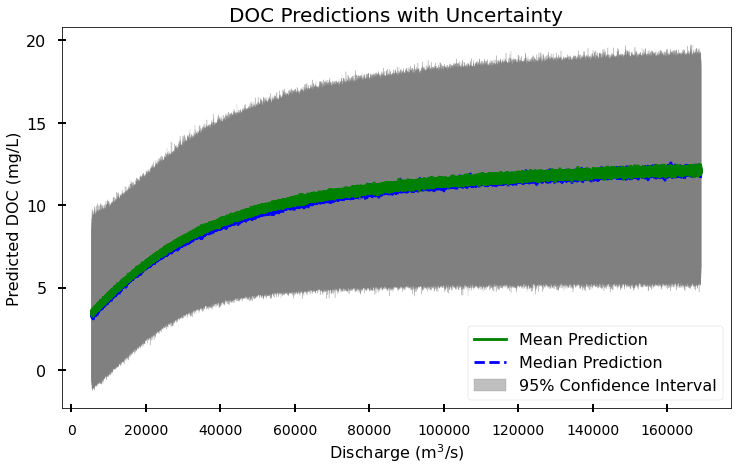

In [16]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='green', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('DOC Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted DOC (mg/L)', fontsize=16)
ax.legend(loc='lower right')
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_DOC_2.png', dpi = 500, bbox_inches='tight')

In [17]:
# Add the DOC mean predictions to the existing dataframe
df_mean_predictions['DOC_Mean_Prediction'] = mean_predictions

<br><br><br>

# Ca

<br><br><br>

Fitted 4PL Model Coefficients:
A = 8.5
B = -3.1
C = 21976.2
D = 24.8
4PL Model Equation: y = 24.8 + (8.5 - 24.8) / (1 + (x / 21976.2)**-3.1)


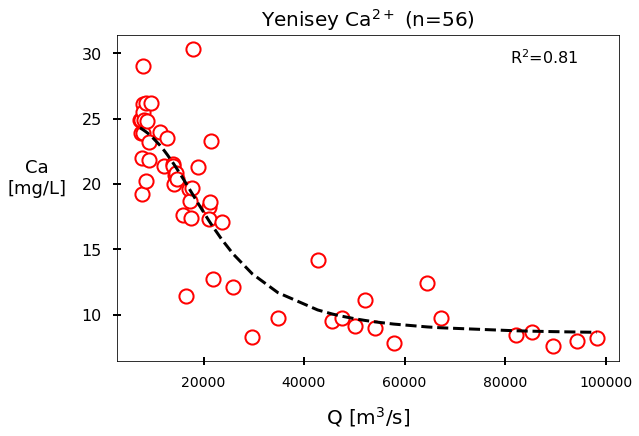

In [18]:
df_dfy = pd.DataFrame()
df_dfy['Ca'] = dfy['Ca']
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['Ca'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['Ca'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['Ca'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Print out the coefficients
print("Fitted 4PL Model Coefficients:")
print(f"A = {A_4PL:.1f}")
print(f"B = {B_4PL:.1f}")
print(f"C = {C_4PL:.1f}")
print(f"D = {D_4PL:.1f}")

# Format and print the resultant equation with one decimal place
equation = f"4PL Model Equation: y = {D_4PL:.1f} + ({A_4PL:.1f} - {D_4PL:.1f}) / (1 + (x / {C_4PL:.1f})**{B_4PL:.1f})"
print(equation)

# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['Ca'].mean())**2) / np.sum((df_dfy['Ca'] - df_dfy['Ca'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['Ca'], c='white', edgecolor='red', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisey Ca$^{{2+}}$ (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('Ca\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.85, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_Ca_1.png', dpi = 500, bbox_inches='tight')

In [19]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

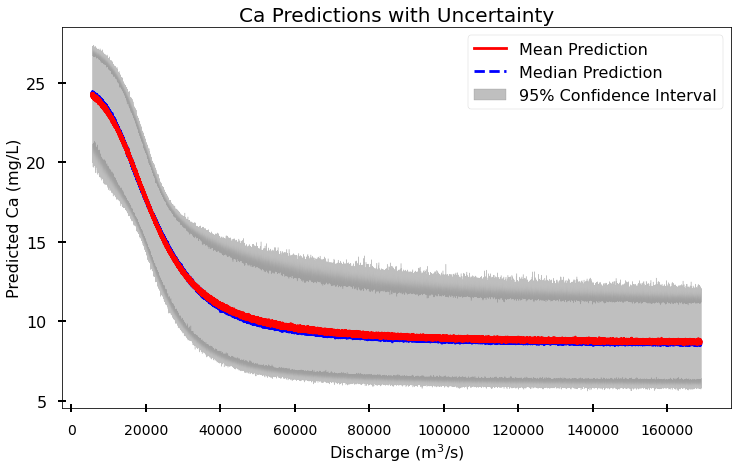

In [20]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='red', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('Ca Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted Ca (mg/L)', fontsize=16)
ax.legend(loc='upper right')
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_Ca_2.png', dpi = 500, bbox_inches='tight')

In [21]:
# Add the DOC mean predictions to the existing dataframe
df_mean_predictions['Ca_Mean_Prediction'] = mean_predictions

<br><br><br>

# SO4

<br><br><br>

Fitted 4PL Model Coefficients:
A = 0.9
B = -2.1
C = 19598.4
D = 5.2
4PL Model Equation: y = 5.2 + (0.9 - 5.2) / (1 + (x / 19598.4)**-2.1)


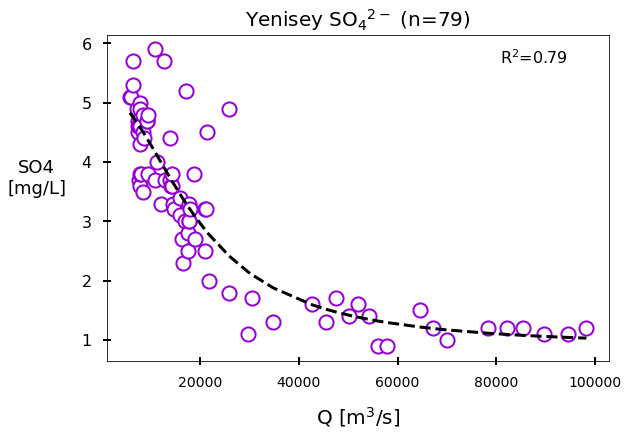

In [22]:
df_dfy = pd.DataFrame()
df_dfy['SO4'] = dfy['SO4']
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['SO4'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['SO4'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['SO4'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Print out the coefficients
print("Fitted 4PL Model Coefficients:")
print(f"A = {A_4PL:.1f}")
print(f"B = {B_4PL:.1f}")
print(f"C = {C_4PL:.1f}")
print(f"D = {D_4PL:.1f}")

# Format and print the resultant equation with one decimal place
equation = f"4PL Model Equation: y = {D_4PL:.1f} + ({A_4PL:.1f} - {D_4PL:.1f}) / (1 + (x / {C_4PL:.1f})**{B_4PL:.1f})"
print(equation)

# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['SO4'].mean())**2) / np.sum((df_dfy['SO4'] - df_dfy['SO4'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['SO4'], c='white', edgecolor='darkviolet', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisey SO$_4$$^{{2-}}$ (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('SO4\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.85, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_SO4_1.png', dpi = 500, bbox_inches='tight')

In [23]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

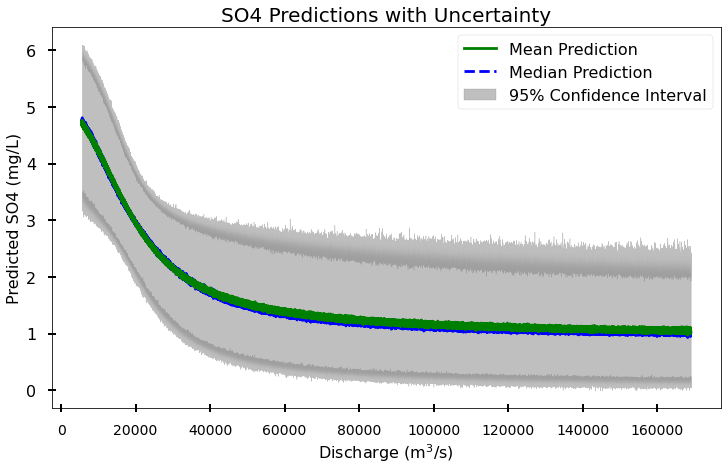

In [24]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='green', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('SO4 Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted SO4 (mg/L)', fontsize=16)
ax.legend(loc='upper right')
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_SO4_2.png', dpi = 500, bbox_inches='tight')

In [25]:
# Add the DOC mean predictions to the existing dataframe
df_mean_predictions['SO4_Mean_Prediction'] = mean_predictions

# F

Fitted 4PL Model Coefficients:
A = 0.0
B = -12.3
C = 25152.3
D = 0.1
4PL Model Equation: y = 0.1 + (0.0 - 0.1) / (1 + (x / 25152.3)**-12.3)


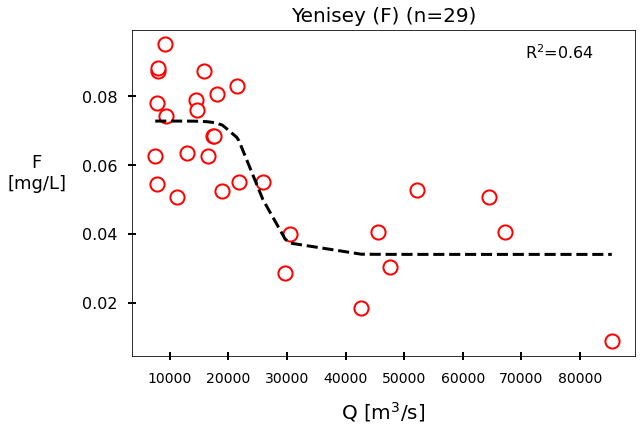

In [26]:
df_dfy = pd.DataFrame()
df_dfy['F'] = dfy['F']
df_dfy['F'] = df_dfy['F'] * (10**-3)
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['F'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['F'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['F'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Print out the coefficients
print("Fitted 4PL Model Coefficients:")
print(f"A = {A_4PL:.1f}")
print(f"B = {B_4PL:.1f}")
print(f"C = {C_4PL:.1f}")
print(f"D = {D_4PL:.1f}")

# Format and print the resultant equation with one decimal place
equation = f"4PL Model Equation: y = {D_4PL:.1f} + ({A_4PL:.1f} - {D_4PL:.1f}) / (1 + (x / {C_4PL:.1f})**{B_4PL:.1f})"
print(equation)

# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['F'].mean())**2) / np.sum((df_dfy['F'] - df_dfy['F'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['F'], c='white', edgecolor='red', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisey (F) (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('F\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.85, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_F_1.png', dpi = 500, bbox_inches='tight')

In [27]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

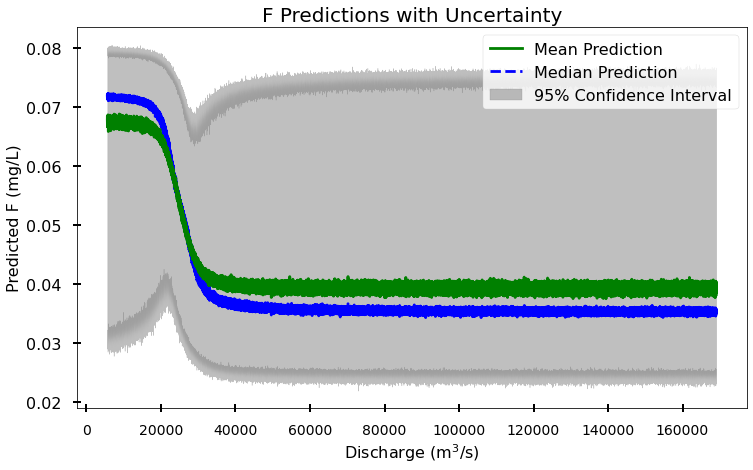

In [28]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='green', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('F Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted F (mg/L)', fontsize=16)
ax.legend(loc='upper right')
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_F_2.png', dpi = 500, bbox_inches='tight')

In [29]:
# Add the DOC mean predictions to the existing dataframe
df_mean_predictions['F_Mean_Prediction'] = mean_predictions

In [30]:
df_mean_predictions

,Discharge,Alk_Mean_Prediction,DOC_Mean_Prediction,Ca_Mean_Prediction,SO4_Mean_Prediction,F_Mean_Prediction
0,5600,71.175463,3.501984,24.346614,4.682326,0.067829
1,5601,71.472616,NaN,24.215120,4.730078,0.067397
2,5602,71.469283,NaN,24.242138,4.728893,0.068012
3,5603,70.814878,3.492419,24.168498,4.702637,0.067335
4,5604,71.032631,NaN,24.202398,4.707356,0.067995
...,...,...,...,...,...,...
163396,168996,21.292488,NaN,8.694609,1.059248,0.039070
163397,168997,21.311398,NaN,8.681130,1.058226,0.039385
163398,168998,21.580506,11.964128,8.744027,1.062530,0.039247
163399,168999,21.179251,12.187452,8.744332,1.048048,0.039123


<br><br><br>

# Mg

<br><br><br>

In [31]:
df_dfy = pd.DataFrame()
df_dfy['Mg'] = dfy['Mg']
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['Mg'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['Mg'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['Mg'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Print out the coefficients
print("Fitted 4PL Model Coefficients:")
print(f"A = {A_4PL:.1f}")
print(f"B = {B_4PL:.1f}")
print(f"C = {C_4PL:.1f}")
print(f"D = {D_4PL:.1f}")

# Format and print the resultant equation with one decimal place
equation = f"4PL Model Equation: y = {D_4PL:.1f} + ({A_4PL:.1f} - {D_4PL:.1f}) / (1 + (x / {C_4PL:.1f})**{B_4PL:.1f})"
print(equation)

# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['Mg'].mean())**2) / np.sum((df_dfy['Mg'] - df_dfy['Mg'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['Mg'], c='white', edgecolor='peru', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisey Mg$^{2+}$ (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('Mg\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.85, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_Mg_1.png', dpi = 500, bbox_inches='tight')

SyntaxError: unexpected EOF while parsing (<fstring>, line 1)

In [ ]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

In [ ]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='green', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('Mg Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted Mg (mg/L)', fontsize=16)
ax.legend(loc='upper right')

fig.savefig('AGRO_Yenisei_Predicted_Mg_2.png', dpi = 500, bbox_inches='tight')

In [ ]:
# Add the DOC mean predictions to the existing dataframe
df_mean_predictions['Mg_Mean_Prediction'] = mean_predictions

# Na

In [ ]:
df_dfy = pd.DataFrame()
df_dfy['Na'] = dfy['Na']
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['Na'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['Na'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['Na'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Print out the coefficients
print("Fitted 4PL Model Coefficients:")
print(f"A = {A_4PL:.1f}")
print(f"B = {B_4PL:.1f}")
print(f"C = {C_4PL:.1f}")
print(f"D = {D_4PL:.1f}")

# Format and print the resultant equation with one decimal place
equation = f"4PL Model Equation: y = {D_4PL:.1f} + ({A_4PL:.1f} - {D_4PL:.1f}) / (1 + (x / {C_4PL:.1f})**{B_4PL:.1f})"
print(equation)

# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['Na'].mean())**2) / np.sum((df_dfy['Na'] - df_dfy['Na'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['Na'], c='white', edgecolor='peru', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisey Na$^+$ (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('Na\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.85, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_Na_1.png', dpi = 500, bbox_inches='tight')

In [ ]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

In [ ]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='green', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('Na Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted Mg (mg/L)', fontsize=16)
ax.legend(loc='upper right')

fig.savefig('AGRO_Yenisei_Predicted_Na_2.png', dpi = 500, bbox_inches='tight')

In [ ]:
# Add the DOC mean predictions to the existing dataframe
df_mean_predictions['Na_Mean_Prediction'] = mean_predictions

# K

In [ ]:
df_dfy = pd.DataFrame()
df_dfy['K'] = dfy['K']
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['K'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['K'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['K'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Print out the coefficients
print("Fitted 4PL Model Coefficients:")
print(f"A = {A_4PL:.1f}")
print(f"B = {B_4PL:.1f}")
print(f"C = {C_4PL:.1f}")
print(f"D = {D_4PL:.1f}")

# Format and print the resultant equation with one decimal place
equation = f"4PL Model Equation: y = {D_4PL:.1f} + ({A_4PL:.1f} - {D_4PL:.1f}) / (1 + (x / {C_4PL:.1f})**{B_4PL:.1f})"
print(equation)

# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['K'].mean())**2) / np.sum((df_dfy['K'] - df_dfy['K'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['K'], c='white', edgecolor='peru', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisey K$^+$ (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('K\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.85, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_K_1.png', dpi = 500, bbox_inches='tight')

In [ ]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

In [ ]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='green', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('K Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted K (mg/L)', fontsize=16)
ax.legend(loc='upper right')

fig.savefig('AGRO_Yenisei_Predicted_K_2.png', dpi = 500, bbox_inches='tight')

In [ ]:
# Add the DOC mean predictions to the existing dataframe
df_mean_predictions['K_Mean_Prediction'] = mean_predictions

In [ ]:
halt

# SiO2

In [ ]:
set_tick_paramsdf_dfy = pd.DataFrame()
df_dfy['SiO2'] = dfy['SiO2']
df_dfy['yq_m3/s']  = dfy['yq_m3/s'] 
df_dfy = df_dfy.sort_values(by='yq_m3/s')
df_dfy = df_dfy.dropna()

# Initial guess for the parameters to help the curve fitting process
initial_guess_4PL = [df_dfy['SiO2'].min(), -1, df_dfy['yq_m3/s'].median(), df_dfy['SiO2'].max()]

# Perform Model Fitting using Curve_Fit with the 4PL function
popt_4PL, pcov_4PL = curve_fit(four_parameter_logistic, df_dfy['yq_m3/s'], df_dfy['SiO2'], p0=initial_guess_4PL, maxfev=10000)

# Extract fitted parameters
A_4PL, B_4PL, C_4PL, D_4PL = popt_4PL

# Compute predictions using the fitted model
df_dfy['4PL_model'] = four_parameter_logistic(df_dfy['yq_m3/s'], A_4PL, B_4PL, C_4PL, D_4PL)

# Compute R-Squared Value for the 4PL model
R2_4PL = np.sum((df_dfy['4PL_model'] - df_dfy['SiO2'].mean())**2) / np.sum((df_dfy['SiO2'] - df_dfy['SiO2'].mean())**2)

# Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df_dfy['yq_m3/s'], df_dfy['4PL_model'], c='black', lw=3, ls='--', zorder=3, label='4PL Fit')
ax.scatter(df_dfy['yq_m3/s'], df_dfy['SiO2'], c='white', edgecolor='peru', s=200, lw=2, ls='-', zorder=2)

# Title and labels
ax.set_title(f'Yenisei (n={df_dfy.shape[0]})', fontsize=20, c='black', pad=8)
ax.set_xlabel('Q [m$^3$/s]', fontsize=20, c='black', labelpad=15)
ax.set_ylabel('SiO2\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax.text(0.85, 0.93, rf"R$^2$={R2_4PL:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.savefig('AGRO_Yenisei_Predicted_SiO2_1.png', dpi = 500, bbox_inches='tight')

In [ ]:
# Extract standard deviations for each parameter from the covariance matrix
d_A_4PL, d_B_4PL, d_C_4PL, d_D_4PL = np.sqrt(np.diag(pcov_4PL))

# Define the range of discharge values
x_range = np.arange(5600, 169001, 1)

# Number of Monte Carlo simulations
n_simulations = 1000

# Initialize an array to store the ensemble of predictions for each x value
ensemble_predictions = np.zeros((len(x_range), n_simulations))

# For each x value, generate an ensemble of predictions
for i, x in enumerate(x_range):
    # Draw A, B, C, and D values from normal distributions
    A_samples = np.random.normal(A_4PL, d_A_4PL, n_simulations)
    B_samples = np.random.normal(B_4PL, d_B_4PL, n_simulations)
    C_samples = np.random.normal(C_4PL, d_C_4PL, n_simulations)
    D_samples = np.random.normal(D_4PL, d_D_4PL, n_simulations)
    
    # Compute predictions for each set of drawn coefficients
    y_samples = D_samples + (A_samples - D_samples) / (1 + (x / C_samples)**B_samples)
    
    # Store the ensemble of predictions
    ensemble_predictions[i] = y_samples

# Compute summary statistics for the predictions
mean_predictions = np.mean(ensemble_predictions, axis=1)
median_predictions = np.median(ensemble_predictions, axis=1)
lower_bound = np.percentile(ensemble_predictions, 2.5, axis=1)  # 2.5 percentile for 95% CI
upper_bound = np.percentile(ensemble_predictions, 97.5, axis=1)  # 97.5 percentile for 95% CI

In [ ]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the mean and median predictions
ax.plot(x_range, mean_predictions, label='Mean Prediction', color='green', zorder=3)
ax.plot(x_range, median_predictions, label='Median Prediction', color='blue', linestyle='--', zorder=2)

# Fill between the upper and lower bounds to represent the 95% confidence interval
ax.fill_between(x_range, lower_bound, upper_bound, 
                color='gray', alpha=0.5, label='95% Confidence Interval', zorder=1)

# Labels, title, and legend
ax.set_title('SiO2 Predictions with Uncertainty', fontsize=20)
ax.set_xlabel('Discharge (m$^3$/s)', fontsize=16)
ax.set_ylabel('Predicted SiO2 (mg/L)', fontsize=16)
ax.legend(loc='upper right')

fig.savefig('AGRO_Yenisei_Predicted_SiO2_2.png', dpi = 500, bbox_inches='tight')

In [ ]:
# Add the DOC mean predictions to the existing dataframe
df_mean_predictions['SiO2_Mean_Prediction'] = mean_predictions

# Check Dataframe

In [ ]:
df_mean_predictions

In [ ]:
halt

<br><br><br>

# Results

<br><br><br>

In [ ]:
nan_count = df_mean_predictions.isna().sum()
print(nan_count)

In [ ]:
from scipy.interpolate import PchipInterpolator

def interpolate_column(data):
    non_nan = ~np.isnan(data)
    interpolator = PchipInterpolator(data[non_nan].index, data[non_nan])
    return interpolator(data.index)

for col in df_mean_predictions.columns:
    df_mean_predictions[col] = interpolate_column(df_mean_predictions[col])

In [ ]:
nan_count = df_mean_predictions.isna().sum()
print(nan_count)

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(12,4))
ax[0].scatter(df_mean_predictions['Discharge'], df_mean_predictions['DOC_Mean_Prediction'], c='white', edgecolor='purple', s=10, lw=1.0)
ax[1].scatter(df_mean_predictions['Discharge'], df_mean_predictions['Alk_Mean_Prediction'], c='white', edgecolor='purple', s=10, lw=1.0)
ax[2].scatter(df_mean_predictions['Discharge'], df_mean_predictions['Ca_Mean_Prediction'], c='white', edgecolor='purple', s=10, lw=1.0)
ax[3].scatter(df_mean_predictions['Discharge'], df_mean_predictions['SO4_Mean_Prediction'], c='white', edgecolor='purple', s=10, lw=1.0)

ax[0].set_title('DOC')
ax[1].set_title('Alk')
ax[2].set_title('Ca')
ax[3].set_title('SO4')

ax[0].set_ylabel('[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)

#ax[0].set_ylim(0, 15)
#ax[1].set_ylim(0, 80)
#ax[2].set_ylim(0, 30)
#ax[3].set_ylim(0, 5)

for ax in ax:
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
    ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)

fig.tight_layout(pad=1)

fig.savefig('AGRO_Yenisei_4PL_Predicted_Chemicals.png', dpi = 500, bbox_inches='tight')

In [ ]:
# Folder for Data
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data')
print(os.getcwd())

# Save CSV
df_mean_predictions.to_csv('AGRO_Regression_Q_Predictions.csv')

In [ ]:
# PYCO2SYS could use F and PO4, maybe do later.

In [ ]:
nan_rows = np.any(np.isnan(ensemble_predictions), axis=1)
problematic_discharges = x_range[nan_rows]
print(problematic_discharges)

In [ ]:
halt

<br><br><br>

# Predicted Values for 1999-2022

<br><br><br>

In [ ]:
# Change Column Name for Merge
dfq = dfq.rename(columns={"yq_m3/s":"Discharge"})

# Convert from [m3/s] to [km3/y]
dfq['q_km3/y'] = (dfq['Discharge']) * (1/(10**9)) * (86400) * (365) 

# Convert Volume Export to Mass Export (Assume FW Density = 999.82 [kg/m3])
dfq['m_kg/y'] = (dfq['Discharge']) * (999.82)  * (86400) * (365) 

# 1 Pg = 10**12 kg = 10**15 g = 10**18 mg
dfq['m_Pg/y'] = (dfq['m_kg/y']) * (10**-12)

# Preview
dfq.head(3)

In [ ]:
# Rename Columns
df_mean_predictions = df_mean_predictions.rename(columns={"Alk_Mean_Prediction":"Alk",
                                                          'DOC_Mean_Prediction': 'DOC',
                                                          'Ca_Mean_Prediction':'Ca',
                                                          'Mg_Mean_Prediction':'Mg',
                                                          'SO4_Mean_Prediction':'SO4',
                                                          'Na_Mean_Prediction':'Na',
                                                          'K_Mean_Prediction':'K',
                                                          'SiO2_Mean_Prediction':'SiO2',
                                                          'F_Mean_Prediction':'F'})

df_mean_predictions.head(3)

In [ ]:
# Reset the index of dfq directly
dfq.reset_index(inplace=True)

# Assuming the discharge column in both dataframes is named 'Discharge'
merged_df = dfq.merge(df_mean_predictions, on='Discharge', how='left')

# Set "Date" as the index again
merged_df.set_index('Date', inplace=True)

merged_df.head()

In [ ]:

# Folder for Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\AGRO_Yenisei_Predicted_Images')
print(os.getcwd())

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12,5), sharex=True)
ax[0].scatter(merged_df.index, merged_df['DOC'], c='white', 
              edgecolor='Green', s=10, lw=1.0)
ax[1].scatter(merged_df.index, merged_df['Alk'], c='white', 
              edgecolor='Red', s=10, lw=1.0)

ax[0].set_ylabel('DOC\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[1].set_ylabel('Alk\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
    #ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
    
fig.savefig('AGRO_Yenisei_4PL_Predicted_1999_2022_DOC_Alk.png', dpi = 500, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(15,10), sharex=True)
ax[0].scatter(merged_df.index, merged_df['DOC'], c='white', 
              edgecolor='Green', s=10, lw=1.0)
ax[1].scatter(merged_df.index, merged_df['Alk'], c='white', 
              edgecolor='Red', s=10, lw=1.0)
ax[2].scatter(merged_df.index, merged_df['Ca'], c='white', 
              edgecolor='salmon', s=10, lw=1.0)
ax[3].scatter(merged_df.index, merged_df['SO4'], c='white', 
              edgecolor='purple', s=10, lw=1.0)

ax[0].set_ylabel('DOC\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[1].set_ylabel('Alk\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[2].set_ylabel('Ca\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[3].set_ylabel('SO4\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
    #ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
    
fig.savefig('AGRO_Yenisei_Predicted_1999_2022_Chemicals.png', dpi = 500, bbox_inches='tight')

##### Check NaNs

In [ ]:
nan_count = merged_df.isna().sum()
print(nan_count)

##### Interpolation with SciPy (PchipInterpolator)

> The PchipInterpolator in scipy performs piecewise cubic Hermite interpolating polynomial (PCHIP) interpolation, which can be thought of as a shape-preserving piecewise polynomial interpolation.

In [ ]:
from scipy.interpolate import PchipInterpolator

def interpolate_column(data):
    non_nan = ~np.isnan(data)
    interpolator = PchipInterpolator(data[non_nan].index, data[non_nan])
    return interpolator(data.index)

for col in merged_df.columns:
    merged_df[col] = interpolate_column(merged_df[col])

In [ ]:
nan_count = merged_df.isna().sum()
print(nan_count)

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12,5), sharex=True)
ax[0].scatter(merged_df.index, merged_df['DOC'], c='white', 
              edgecolor='Green', s=10, lw=1.0)
ax[1].scatter(merged_df.index, merged_df['Alk'], c='white', 
              edgecolor='Red', s=10, lw=1.0)

ax[0].set_ylabel('DOC\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[1].set_ylabel('Alk\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
    #ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
    
fig.savefig('AGRO_Yenisei_4PL_Predicted_1999_2022_DOC_Alk_interpolated.png', dpi = 500, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(15,10), sharex=True)
ax[0].scatter(merged_df.index, merged_df['DOC'], c='white', 
              edgecolor='Green', s=10, lw=1.0)
ax[1].scatter(merged_df.index, merged_df['Alk'], c='white', 
              edgecolor='Red', s=10, lw=1.0)
ax[2].scatter(merged_df.index, merged_df['Ca'], c='white', 
              edgecolor='salmon', s=10, lw=1.0)
ax[3].scatter(merged_df.index, merged_df['SO4'], c='white', 
              edgecolor='purple', s=10, lw=1.0)

ax[0].set_ylabel('DOC\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[1].set_ylabel('Alk\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[2].set_ylabel('Ca\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[3].set_ylabel('SO4\n[mg/L]', fontsize=18, c='black', labelpad=45, rotation=0)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
    #ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
    
fig.savefig('AGRO_Yenisei_Predicted_1999_2022_Chemicals_interpolated.png', dpi = 500, bbox_inches='tight')

<br><br><br>

# Mass

- FW Density = 999.820 [kg/m^3]
- 1 [L] = 10^-3 [m3]
- 1 [mg] = 10^6 [kg]
- 1 [ton] = 10**3 [kg] = 10**9[mg]

<br><br><br>

In [ ]:
FW_density = 999.820
mass_per_liter  = FW_density / 1000  # [kg/L]

merged_df['DOC_mgkg'] = merged_df['DOC'] / mass_per_liter
merged_df['Alk_mgkg'] = merged_df['Alk'] / mass_per_liter
merged_df['Ca_mgkg'] = merged_df['Ca'] / mass_per_liter
merged_df['Mg_mgkg'] = merged_df['Mg'] / mass_per_liter
merged_df['SO4_mgkg'] = merged_df['SO4'] / mass_per_liter
merged_df['Na_mgkg'] = merged_df['Na'] / mass_per_liter
merged_df['K_mgkg'] = merged_df['K'] / mass_per_liter

In [ ]:
# [mg/y] >>> [tons/y] === 
merged_df['F_doc_tons_y'] = merged_df['DOC_mgkg'] * merged_df['m_kg/y'] * (10**-9)
merged_df['F_alk_tons_y'] = merged_df['Alk_mgkg'] * merged_df['m_kg/y'] * (10**-9)
merged_df['F_ca_tons_y'] = merged_df['Ca_mgkg'] * merged_df['m_kg/y'] * (10**-9)
merged_df['F_mg_tons_y'] = merged_df['Mg_mgkg'] * merged_df['m_kg/y'] * (10**-9)
merged_df['F_so4_tons_y'] = merged_df['SO4_mgkg'] * merged_df['m_kg/y'] * (10**-9)
merged_df['F_Na_tons_y'] = merged_df['Na_mgkg'] * merged_df['m_kg/y'] * (10**-9)
merged_df['F_K_tons_y'] = merged_df['K_mgkg'] * merged_df['m_kg/y'] * (10**-9)

# [mg/y] >>> [Pg/y]
merged_df['F_doc_Tg_y'] = merged_df['DOC_mgkg'] * merged_df['m_kg/y'] * (10**-15)
merged_df['F_alk_Tg_y'] = merged_df['Alk_mgkg'] * merged_df['m_kg/y'] * (10**-15)
merged_df['F_ca_Tg_y'] = merged_df['Ca_mgkg'] * merged_df['m_kg/y'] * (10**-15)
merged_df['F_mg_Tg_y'] = merged_df['Mg_mgkg'] * merged_df['m_kg/y'] * (10**-15)
merged_df['F_so4_Tg_y'] = merged_df['SO4_mgkg'] * merged_df['m_kg/y'] * (10**-15)
merged_df['F_Na_Tg_y'] = merged_df['Na_mgkg'] * merged_df['m_kg/y'] * (10**-15)
merged_df['F_K_Tg_y'] = merged_df['K_mgkg'] * merged_df['m_kg/y'] * (10**-15)

# [mg/y] >>> [Pg/y]
merged_df['F_doc_Pg_y'] = merged_df['DOC_mgkg'] * merged_df['m_kg/y'] * (10**-18)
merged_df['F_alk_Pg_y'] = merged_df['Alk_mgkg'] * merged_df['m_kg/y'] * (10**-18)
merged_df['F_ca_Pg_y'] = merged_df['Ca_mgkg'] * merged_df['m_kg/y'] * (10**-18)
merged_df['F_mg_Pg_y'] = merged_df['Mg_mgkg'] * merged_df['m_kg/y'] * (10**-18)
merged_df['F_so4_Pg_y'] = merged_df['SO4_mgkg'] * merged_df['m_kg/y'] * (10**-18)
merged_df['F_Na_Pg_y'] = merged_df['Na_mgkg'] * merged_df['m_kg/y'] * (10**-18)
merged_df['F_K_Pg_y'] = merged_df['K_mgkg'] * merged_df['m_kg/y'] * (10**-18)

In [ ]:
merged_df

In [ ]:
# Folder for Data
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data')
print(os.getcwd())

# Save CSV
merged_df.to_csv('AGRO_4PL_Predicted_PYCO2SYS.csv')

In [ ]:
merged_df.head(5)

In [ ]:
# Folder for Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\AGRO_Yenisei_Predicted_Images')
print(os.getcwd())

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(15,10), sharex=True)
ax[0].scatter(merged_df.index, merged_df['F_doc_tons_y'], c='white', edgecolor='Green', s=10, lw=1.0)
ax[1].scatter(merged_df.index, merged_df['F_alk_tons_y'], c='white', edgecolor='Red', s=10, lw=1.0)
ax[2].scatter(merged_df.index, merged_df['F_ca_tons_y'], c='white', edgecolor='salmon', s=10, lw=1.0)
ax[3].scatter(merged_df.index, merged_df['F_so4_tons_y'], c='white', edgecolor='purple', s=10, lw=1.0)
ax[0].set_title('Mass Export', fontsize=24, c='black',)
ax[3].set_xlabel('Year', fontsize=20, c='black', labelpad=15)
ax[0].set_ylabel('DOC\n[tons/y]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[1].set_ylabel('Alk\n[tons/y]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[2].set_ylabel('Ca\n[tons/y]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[3].set_ylabel('SO4\n[tons/y]', fontsize=18, c='black', labelpad=45, rotation=0)
    
for ax in ax:
    ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
    #ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
    
fig.savefig('AGRO_Yenisei_Predicted_1999_2022_mass_tons.png', dpi = 500, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(15,10), sharex=True)
ax[0].scatter(merged_df.index, merged_df['F_doc_Tg_y'], c='white', edgecolor='Green', s=10, lw=1.0)
ax[1].scatter(merged_df.index, merged_df['F_alk_Tg_y'], c='white', edgecolor='Red', s=10, lw=1.0)
ax[2].scatter(merged_df.index, merged_df['F_ca_Tg_y'], c='white', edgecolor='salmon', s=10, lw=1.0)
ax[3].scatter(merged_df.index, merged_df['F_so4_Tg_y'], c='white', edgecolor='purple', s=10, lw=1.0)

ax[0].set_title('Mass Export\n(1 Tg = 10$^{12}$g = 10$^{6}$tons)', fontsize=24, c='black',)
ax[3].set_xlabel('Month', fontsize=20, c='black', labelpad=15)

ax[0].set_ylabel('DOC\n[Tg/y]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[1].set_ylabel('Alk\n[Tg/y]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[2].set_ylabel('Ca\n[Tg/y]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[3].set_ylabel('SO4\n[Tg/y]', fontsize=18, c='black', labelpad=45, rotation=0)

#ax[0].set_ylabel('DOC\n[x10$^{15}$g/y]', fontsize=18, c='black', labelpad=45, rotation=0)
#ax[1].set_ylabel('Alk\n[x10$^{15}$g/y]', fontsize=18, c='black', labelpad=45, rotation=0)
#ax[2].set_ylabel('Ca\n[x10$^{15}$g/y]', fontsize=18, c='black', labelpad=45, rotation=0)
#x[3].set_ylabel('SO4\n[x10$^{15}$g/y]', fontsize=18, c='black', labelpad=45, rotation=0)
    
for ax in ax:
    ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
    #ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
    
fig.savefig('AGRO_Yenisei_Predicted_1999_2022_mass_Tg.png', dpi = 500, bbox_inches='tight')

In [ ]:
merged_df['F_doc_Tg_y'].mean()

In [ ]:
merged_df['F_alk_Tg_y'].mean()

<br><br><br>

# Annual Mean and Sum

<br><br><br>

In [ ]:
# Annual-Averaged Groupby (Mean, Mean, Max, Min)
dfq_annual_mean = merged_df.groupby(merged_df.index.year).mean()
dfq_annual_sum = merged_df.groupby(merged_df.index.year).sum()

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(10,10), sharex=True)

ax[0].plot(dfq_annual_sum.index, dfq_annual_sum['F_doc_Pg_y'], color='green', lw=1.0, zorder=0)
ax[1].plot(dfq_annual_sum.index, dfq_annual_sum['F_alk_Pg_y'], color='red', lw=1.0, zorder=0)
ax[2].plot(dfq_annual_sum.index, dfq_annual_sum['F_ca_Pg_y'], color='salmon', lw=1.0, zorder=0)
ax[3].plot(dfq_annual_sum.index, dfq_annual_sum['F_so4_Pg_y'], color='purple', lw=1.0, zorder=0)

ax[0].scatter(dfq_annual_sum.index, dfq_annual_sum['F_doc_Pg_y'], c='green', edgecolor='black', s=300, lw=1.0)
ax[1].scatter(dfq_annual_sum.index, dfq_annual_sum['F_alk_Pg_y'], c='red', edgecolor='black', s=300, lw=1.0)
ax[2].scatter(dfq_annual_sum.index, dfq_annual_sum['F_ca_Pg_y'], c='salmon', edgecolor='black', s=300, lw=1.0)
ax[3].scatter(dfq_annual_sum.index, dfq_annual_sum['F_so4_Pg_y'], c='purple', edgecolor='black', s=300, lw=1.0)

ax[0].set_title('Annual Sum Mass Export\n(1 Pg = 10$^{15}$g = 10$^{9}$tons)', fontsize=24, c='black',)
ax[3].set_xlabel('Year', fontsize=20, c='black', labelpad=15)

ax[0].set_ylabel('DOC\n[Pg]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[1].set_ylabel('Alk\n[Pg]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[2].set_ylabel('Ca\n[Pg]', fontsize=18, c='black', labelpad=45, rotation=0)
ax[3].set_ylabel('SO4\n[Pg]', fontsize=18, c='black', labelpad=45, rotation=0)

#ax[0].set_ylabel('DOC\n[x10$^{15}$g/y]', fontsize=18, c='black', labelpad=45, rotation=0)
#ax[1].set_ylabel('Alk\n[x10$^{15}$g/y]', fontsize=18, c='black', labelpad=45, rotation=0)
#ax[2].set_ylabel('Ca\n[x10$^{15}$g/y]', fontsize=18, c='black', labelpad=45, rotation=0)
#x[3].set_ylabel('SO4\n[x10$^{15}$g/y]', fontsize=18, c='black', labelpad=45, rotation=0)
    
for ax in ax:
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14, width=2)
    #ax.axvline(2011, lw=1, color='grey', ls='--', zorder=0)
    ax.axvline(2012, lw=1, color='grey', ls='--', zorder=0)
    #ax.axvline(2013, lw=1, color='grey', ls='--', zorder=0)

fig.tight_layout(pad=1)

fig.savefig('AGRO_Yenisei_Predicted_1999_2022_annual_sum_mass_Pg.png', dpi = 500, bbox_inches='tight')

###### 

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(dfq_annual_mean.index, dfq_annual_mean['Alk'], c = 'black', lw=1, ls='-',label='Obs', zorder=1)
ax.scatter(dfq_annual_mean.index, dfq_annual_mean['Alk'], edgecolor='black', color='deepskyblue', s=300, lw=1, zorder=2)
ax.set_title('Yenisei River\nAnnual Mean Discharge', fontsize=24, c='black', pad=15)
ax.set_ylabel('Q [km$^3$/y]', fontsize=24, c='black', labelpad=20, rotation=90)
ax.set_xlabel('Year', fontsize=24, c='black', labelpad=20)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.xaxis.set_tick_params(direction='inout',length=8, labelsize=16)
ax.xaxis.set_tick_params(which='minor', direction='in', length=3)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout', length=8, labelsize=16)
#ax.set_ylim(400,800)
ax.axhline(dfq_annual_mean['Alk'].mean(), lw=1, ls='--', c='grey', zorder=0)
ax.grid(color='black', alpha=0.05)
ax.text(0.27, 0.2, 'Q$_{mean}$  =  58.5 [mg/L]', fontsize=18, ha='center', va='center',transform=ax.transAxes)
#fig.savefig('ArcticGRO_Yenisei_Annual_Q1.png', dpi = 500, bbox_inches='tight')